# EasyOCR Evaluation - zeilenbasiert

In diesem Notebook wird der OCR von EasyOCR evaluiert.   
Dazu wird der von EasyOCR extrahierte Text zeilenweise mit den passenden Zeilen des Ground Truth gematcht und WER und CER berechnet.  
Die Ergebnisse dienen dazu die Performance mit anderen OCR-Modellen, z.B. Tesseract, zu vergleichen

#### 1. Textextraktion
    1.1 auf einem Beipielbild   
    1.2 auf dem gesamten Datensatz

#### 2. Evaluation
    2.1 Berechnung Erkennungsrate / CER / WER
    2.2 Berechnung CER / WER auf "normalisiertem" Text

#### 3. weitere Analysen
    3.1 CER und WER je Bildkategorie
    3.2 Erkennungsrate je Bildkatgeorie
    3.3 weitere Analysen

---

### 1. Textextraktion
---

#### 1.1 Textextraktion auf einem einzelnen Bild 

In [1]:
import easyocr

In [2]:
reader = easyocr.Reader(['de'])  

Das Ergebnis wird zeilenweise als String ausgegeben, ohne die Anzeige der Boundingbox, dafür wurde detail auf "0" gesetzt

In [4]:
result = reader.readtext('../../data/images/insta_images/0001.jpg', detail=1) # bei 0 wird boundingbox wird nicht angezeigt
print(result)

[([[175, 201], [943, 201], [943, 335], [175, 335]], 'SPRACHCAFE', 0.9974398815543888), ([[131, 351], [981, 351], [981, 459], [131, 459]], 'WEIFNACHTSFEIER', 0.4926375189490662), ([[543, 753], [805, 753], [805, 795], [543, 795]], 'DIENSTAG 21.12_', 0.9412396003131693), ([[497, 797], [859, 797], [859, 839], [497, 839]], 'OLOF-PALME ZENTRUM', 0.8671259180937123), ([[619, 851], [739, 851], [739, 891], [619, 891]], '19 UHR', 0.9696392062942848), ([[453, 901], [903, 901], [903, 943], [453, 943]], 'WIR FREUEN UNS AUF EUCH!', 0.4612888053121199)]


---

#### 1.2 Textextraktion auf gesamten Datensatz - zeilenweise Ausgabe / Zeilen gematcht

In [7]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD


IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"



### Hilfsfunktion ###

# Textextraktion mit EasyOCR erfolgt zeilenweise
def extract_ocr_lines(image_path):
    return reader.readtext(image_path, detail=0)


### Hauptfunktion ###

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines(img_path)
    matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = ocr_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None,
        "ocr_easyocr": ocr_lines
    })

df_results = pd.DataFrame(ergebnisse)
display(df_results)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_easyocr
0,0001.jpg,6,6,6,0.022222,0.250000,0.976984,0.750000,"[SPRACHCAFE, WEIFNACHTSFEIER, DIENSTAG 21.12_,..."
1,0002.jpg,7,7,6,0.194740,0.416667,0.799624,0.583333,"[SchlIEsst Eucx Any, EI Videc & Contert, nIcht..."
2,0003.jpg,11,18,6,0.529826,0.863636,0.500103,0.272727,"[Gedenkkundgebung und, antifaschistische Demon..."
3,0004.jpg,11,28,10,0.101010,0.136364,0.897727,0.863636,"[FEIERABEND, KULTUR, NETZ, Meiendorf, SINGEN, ..."
4,0006.jpg,8,8,6,0.365391,0.729167,0.654911,0.250000,"[UI:i:n, DIESTADTE, GESTOHLEN, @EBTISIE, @iunt..."
...,...,...,...,...,...,...,...,...,...
195,0238.jpg,13,24,5,0.708948,0.935897,0.294600,0.064103,"[BLEIBERECHTSKXMIPF, DEN"", A8.00, 20.00 FLINTA..."
196,0239.jpg,11,21,2,0.851010,1.000000,0.154500,0.000000,"[Herglssssbe, Fhbeiesranrgfe, 8€, 4, PUNA, Abe..."
197,0240.jpg,10,13,8,0.222620,0.453333,0.781926,0.646667,"[#KeinFussbreit!, Antisemitismus und, Rassismu..."
198,0241.jpg,17,19,13,0.265601,0.387582,0.740367,0.367647,"[[paziergang mit dem Grundgesetz], 19.12.2020,..."


---
### 2. Evaluation
---

#### 2.1 Berechnung Erkennungsrate / CER / WER

In [8]:
df_results["recognition_rate"] = df_results["matched_lines"] / df_results["gt_lines"]

In [10]:
df_results.to_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv", index=False)

In [11]:
# Durchschnitt berechnen
mean_cer = df_results["mean_cer"].mean()
mean_wer = df_results["mean_wer"].mean()
mean_ER = df_results["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.722
CER: 0.338
WER: 0.525


#### 2.1 Berechnung CER / WER auf "normalisiertem" Text

Der OCR Output wird von unnötigen Leerzeichen und Tabs bereinigt. Der so "normalisierte" Text wird nochmals auf CER und WER geprüft, um zu untersuchen ob dies Einfluss auf die Ergebnisse hat

In [12]:
import os
import json
import pandas as pd


import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD 


IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"

### Hilfsfunktion ###

# Textextraktion mit EasyOCR erfolgt zeilenweise
def extract_ocr_lines(image_path):
    return reader.readtext(image_path, detail=0)

def normalize_text(ocr_text):
    return ' '.join(str(ocr_text).split()) if pd.notna(ocr_text) else ''

### Hauptfunktion ###

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines(img_path)
    ocr_lines_normalized = [normalize_text(line) for line in ocr_lines]
    matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines_normalized)
    total_matches = 0
    cer_list, wer_list, char_acc_list, word_acc_list = [], [], [], []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = ocr_lines_normalized[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            cer_list.append(cer_score)
            wer_list.append(wer_score)
            char_acc_list.append(char_acc)
            word_acc_list.append(word_acc)
            total_matches += 1
        else:
            cer_list.append(1.0)
            wer_list.append(1.0)
            char_acc_list.append(0.0)
            word_acc_list.append(0.0)

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(cer_list) / total_gt if total_gt else None,
        "mean_wer": sum(wer_list) / total_gt if total_gt else None,
        "mean_char_acc": sum(char_acc_list) / total_gt if total_gt else None,
        "mean_word_acc": sum(word_acc_list) / total_gt if total_gt else None,
        "ocr_easyocr_normalized": ocr_lines_normalized
    })

df_results_normalized = pd.DataFrame(ergebnisse)
display(df_results_normalized)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_easyocr_normalized
0,0001.jpg,6,6,6,0.022222,0.250000,0.976984,0.750000,"[SPRACHCAFE, WEIFNACHTSFEIER, DIENSTAG 21.12_,..."
1,0002.jpg,7,7,6,0.194740,0.416667,0.799624,0.583333,"[SchlIEsst Eucx Any, EI Videc & Contert, nIcht..."
2,0003.jpg,11,18,6,0.529826,0.863636,0.500103,0.272727,"[Gedenkkundgebung und, antifaschistische Demon..."
3,0004.jpg,11,28,10,0.101010,0.136364,0.897727,0.863636,"[FEIERABEND, KULTUR, NETZ, Meiendorf, SINGEN, ..."
4,0006.jpg,8,8,6,0.365391,0.729167,0.654911,0.250000,"[UI:i:n, DIESTADTE, GESTOHLEN, @EBTISIE, @iunt..."
...,...,...,...,...,...,...,...,...,...
195,0238.jpg,13,24,5,0.708948,0.935897,0.294600,0.064103,"[BLEIBERECHTSKXMIPF, DEN"", A8.00, 20.00 FLINTA..."
196,0239.jpg,11,21,2,0.851010,1.000000,0.154500,0.000000,"[Herglssssbe, Fhbeiesranrgfe, 8€, 4, PUNA, Abe..."
197,0240.jpg,10,13,8,0.222620,0.453333,0.781926,0.646667,"[#KeinFussbreit!, Antisemitismus und, Rassismu..."
198,0241.jpg,17,19,13,0.265601,0.387582,0.740367,0.367647,"[[paziergang mit dem Grundgesetz], 19.12.2020,..."


In [15]:
df_results_normalized["recognition_rate"] = df_results_normalized["matched_lines"] / df_results_normalized["gt_lines"]

In [16]:
# Durchschnitt berechnen
mean_cer = df_results_normalized["mean_cer"].mean()
mean_wer = df_results_normalized["mean_wer"].mean()
mean_ER = df_results_normalized["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.722
CER: 0.338
WER: 0.525


----> Es gibt keine Unterschied in den Werten des "normalisierten" und "originalen" OCR-Outputs.    
Der Text war schon zuvor frei von unnötigen Leerzeichen oder Tabs. Die Ergebnisse/Werte des normailisierten Textes werden deshalb nicht eigens gespeichert.

---
### 3. weitere Analysen
---

In [17]:
import pandas as pd

df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")
df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv")

In [18]:
# Nur relevante Spalten
df_pics_little = df_pics[["file_name", "category"]]

merged_df = df.merge(df_pics_little, on="file_name", how="left")

merged_df.head()

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_easyocr,recognition_rate,category
0,0001.jpg,6,6,6,0.022222,0.250000,0.976984,0.750000,"['SPRACHCAFE', 'WEIFNACHTSFEIER', 'DIENSTAG 21...",1.000000,noisy
1,0002.jpg,7,7,6,0.194740,0.416667,0.799624,0.583333,"['SchlIEsst Eucx Any', 'EI Videc & Contert', '...",0.857143,noisy
2,0003.jpg,11,18,6,0.529826,0.863636,0.500103,0.272727,"['Gedenkkundgebung und', 'antifaschistische De...",0.545455,noisy
3,0004.jpg,11,28,10,0.101010,0.136364,0.897727,0.863636,"['FEIERABEND', 'KULTUR', 'NETZ', 'Meiendorf', ...",0.909091,noisy
4,0006.jpg,8,8,6,0.365391,0.729167,0.654911,0.250000,"['UI:i:n', 'DIESTADTE', 'GESTOHLEN', '@EBTISIE...",0.750000,noisy


#### 3.1 CER und WER je Bildkategorie

In [19]:
CER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
CER_by_category = CER_by_category.round(2)
CER_by_category = CER_by_category.sort_values(ascending=True)

print(CER_by_category)

category
simple    22.25
skewed    32.34
noisy     33.40
photo     41.88
fancy     45.91
Name: mean_cer, dtype: float64


In [20]:
WER_by_category = merged_df.groupby("category")["mean_wer"].mean() * 100
WER_by_category = WER_by_category.round(2)
WER_by_category = WER_by_category.sort_values(ascending=True)
print(WER_by_category)

category
simple    38.78
skewed    51.82
noisy     55.83
fancy     62.73
photo     65.32
Name: mean_wer, dtype: float64


#### 3.2 Erkennungsrate je Bildkatgeorie

In [21]:
Erkennungsrate_by_category = merged_df.groupby("category")["recognition_rate"].mean() * 100
Erkennungsrate_by_category = Erkennungsrate_by_category.round(2)
Erkennungsrate_by_category = Erkennungsrate_by_category.sort_values(ascending=False)

print(Erkennungsrate_by_category)

category
simple    82.53
skewed    73.62
noisy     72.47
photo     64.97
fancy     61.32
Name: recognition_rate, dtype: float64


---

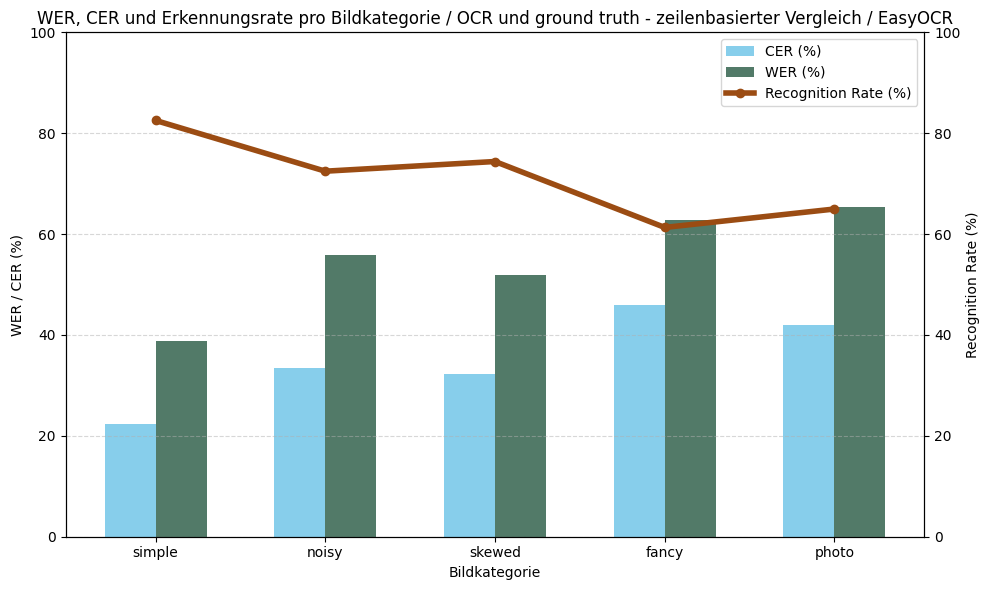

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Kategorien und Werte
categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
wer = [38.78, 55.83, 51.84, 62.73, 65.32]          
cer = [22.25, 33.40, 32.34, 45.91, 41.88]         
recognition_rate = [82.53, 72.47, 74.39, 61.32, 64.97]  


# DataFrame
df = pd.DataFrame({
    'category': categories,
    'WER': wer,
    'CER': cer,
    'RecognitionRate': recognition_rate
})

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(categories))
bar_width = 0.30

# Balken für WER und CER
ax1.bar(x, df['CER'], width=bar_width, label='CER (%)', color='skyblue')
ax1.bar([i + bar_width for i in x], df['WER'], width=bar_width, label='WER (%)', color='#527a68')

ax1.set_ylabel('WER / CER (%)')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Bildkategorie')
ax1.set_xticks([i + bar_width / 2 for i in x])
ax1.set_xticklabels(categories)

# Zweite Y-Achse für Erkennungsrate
ax2 = ax1.twinx()
ax2.plot([i + bar_width / 2 for i in x], df['RecognitionRate'], label='Recognition Rate (%)', color='#9B4C13', marker='o', linewidth=4)
ax2.set_ylabel('Recognition Rate (%)')
ax2.set_ylim(0, 100)

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('WER, CER und Erkennungsrate pro Bildkategorie / OCR und ground truth - zeilenbasierter Vergleich / EasyOCR')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

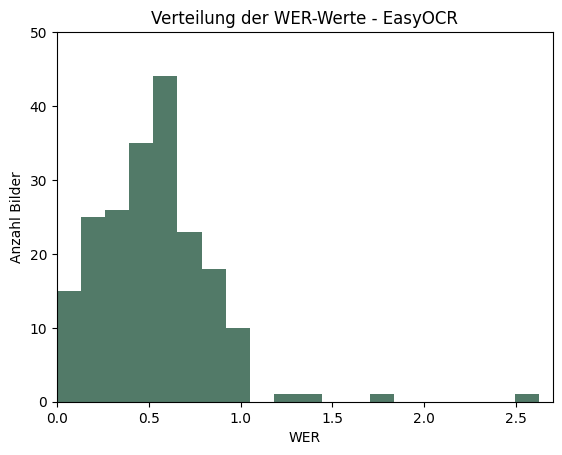

In [118]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv") 
wer_values = df["mean_wer"] 

plt.hist(wer_values, bins=20, color='#527a68')
plt.ylim(0, 50)
plt.xlim(0, 2.7)
plt.xlabel('WER')
plt.ylabel('Anzahl Bilder')
plt.title('Verteilung der WER-Werte - EasyOCR')
plt.grid(False)
plt.show()



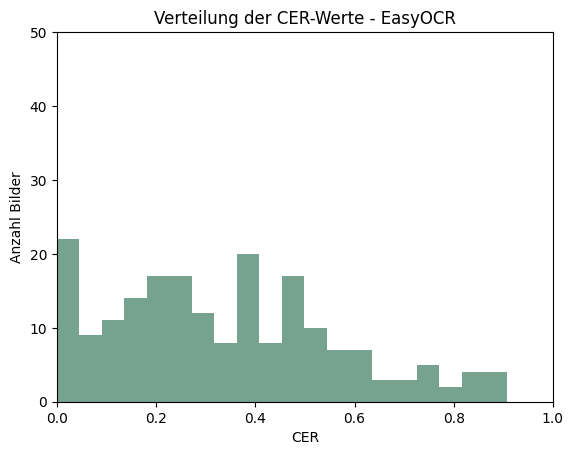

In [122]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv") 
cer_values = df["mean_cer"] 

plt.hist(cer_values, bins=20, color='#76a38f')
plt.ylim(0, 50)
plt.xlim(0, 1)
plt.xlabel('CER')
plt.ylabel('Anzahl Bilder')
plt.title('Verteilung der CER-Werte - EasyOCR')
plt.grid(False)
plt.show()

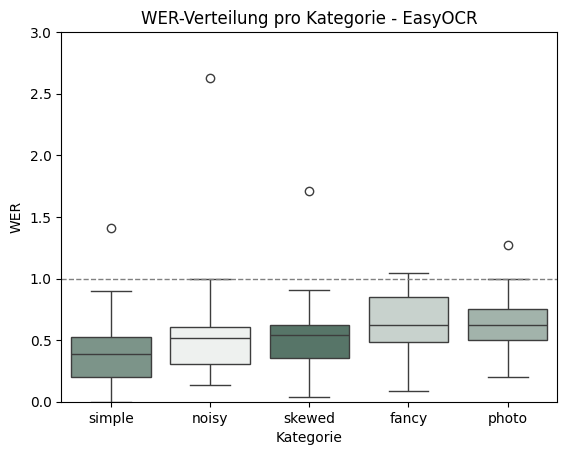

In [121]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise_with_category.csv") 

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']


sns.boxplot(data=df, x='category', y='mean_wer',  hue='category', palette='light:#527a68', order=categories)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('WER-Verteilung pro Kategorie - EasyOCR')
plt.xlabel('Kategorie')
plt.ylabel('WER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

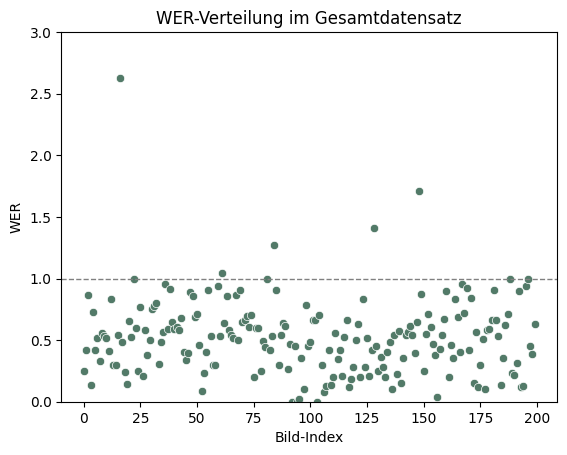

In [113]:
sns.scatterplot(x=range(len(df)), y=df['mean_wer'], color='#527a68')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('WER-Verteilung im Gesamtdatensatz')
plt.xlabel('Bild-Index')
plt.ylabel('WER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

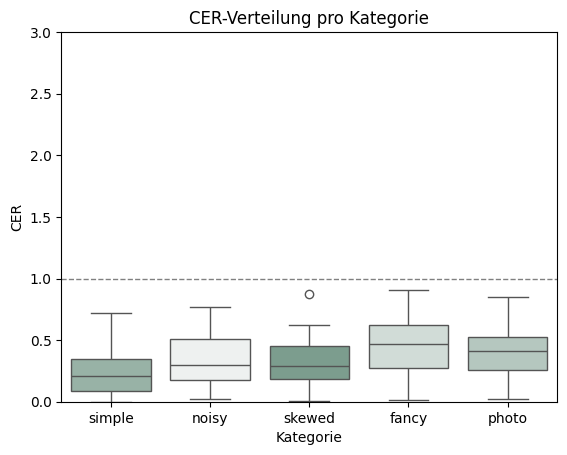

In [115]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise_with_category.csv") 

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
sns.boxplot(data=df, x='category', y='mean_cer',  hue='category', palette='light:#76a38f', order=categories)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('CER-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('CER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

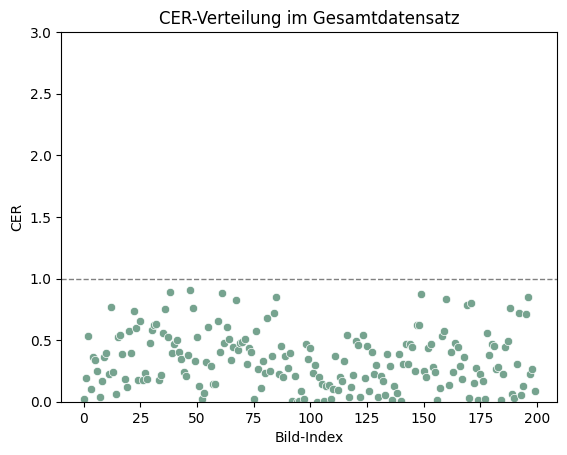

In [116]:
sns.scatterplot(x=range(len(df)), y=df['mean_cer'], color='#76a38f')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('CER-Verteilung im Gesamtdatensatz')
plt.xlabel('Bild-Index')
plt.ylabel('CER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

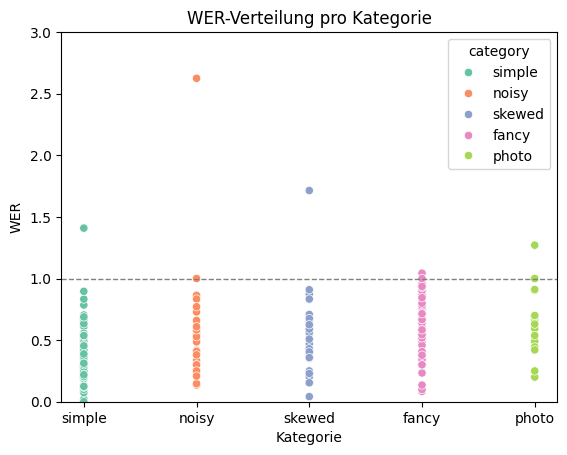

In [86]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise_with_category.csv") 
categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
df['category'] = pd.Categorical(df['category'], categories=categories, ordered=True)

sns.scatterplot(data=df, x='category', y='mean_wer',  hue='category', palette='Set2')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('WER-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('WER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

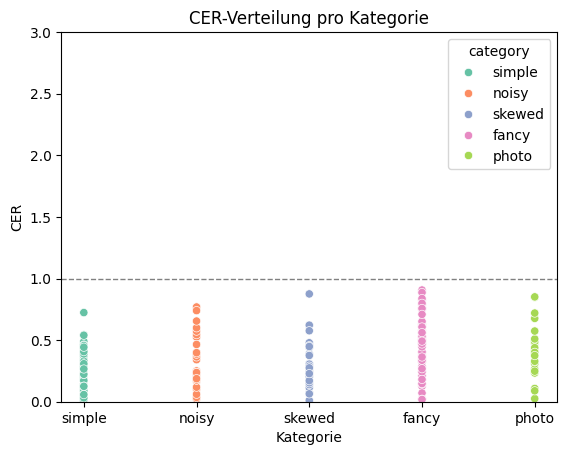

In [87]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise_with_category.csv") 

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
df['category'] = pd.Categorical(df['category'], categories=categories, ordered=True)

sns.scatterplot(data=df, x='category', y='mean_cer', hue='category', palette='Set2')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('CER-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('CER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

---

### 3.3 weitere Analysen

In [23]:
# images bei denen kein Text extrahiert wurde
merged_df[merged_df['ocr_lines'] == 0].groupby('category').size()


Series([], dtype: int64)

In [24]:
# images bei denen keine Zeile des OCR textes mit dem einer Zeile des ground truth matcht
merged_df[merged_df['matched_lines'] == 0].groupby('category').size()

Series([], dtype: int64)

In [25]:
# images die eine guten WER haben 
merged_df[merged_df['mean_wer'] < 0.11].groupby('category').size()

category
fancy     2
simple    7
skewed    1
dtype: int64

In [37]:
merged_df.loc[merged_df['mean_wer'] < 0.11, 'file_name']

52     0064.jpg
92     0121.jpg
94     0123.jpg
95     0124.jpg
97     0128.jpg
103    0134.jpg
106    0137.jpg
136    0173.jpg
156    0199.jpg
177    0220.jpg
Name: file_name, dtype: object

In [39]:
# images die eine guten CER haben 
merged_df[merged_df['mean_cer'] < 0.03].groupby('category').size()

category
fancy      3
noisy      1
photo      1
simple    10
skewed     2
dtype: int64

In [40]:
merged_df.loc[merged_df['mean_cer'] < 0.03, 'file_name']


0       0001.jpg
52      0064.jpg
75      0100.jpg
92      0121.jpg
94      0123.jpg
95      0124.jpg
97      0128.jpg
103     0134.jpg
106     0137.jpg
109    0142.jpeg
136     0173.jpg
140     0179.jpg
156     0199.jpg
170     0213.jpg
174     0217.jpg
177     0220.jpg
184     0227.jpg
Name: file_name, dtype: object

In [27]:
# images die eine schlechte recognition rate haben
print(merged_df.loc[merged_df["recognition_rate"] < 0.2, "file_name"])

38     0046.jpeg
47      0059.jpg
61      0080.jpg
149     0191.jpg
196     0239.jpg
Name: file_name, dtype: object


In [41]:
merged_df[merged_df["recognition_rate"] < 0.2].groupby('category').size()

category
fancy     3
photo     1
skewed    1
dtype: int64

In [31]:
# images die eine gute recognition rate haben
print(merged_df.loc[merged_df["recognition_rate"] > 0.99, "file_name"])

0       0001.jpg
7       0010.jpg
14      0017.jpg
33     0040.jpeg
52      0064.jpg
53      0066.jpg
75      0100.jpg
92      0121.jpg
94      0123.jpg
95      0124.jpg
96     0127.jpeg
97      0128.jpg
103     0134.jpg
106     0137.jpg
109    0142.jpeg
110     0143.jpg
112     0146.jpg
117     0152.jpg
122     0157.jpg
130     0166.jpg
133    0170.jpeg
136     0173.jpg
140     0179.jpg
156     0199.jpg
157     0200.jpg
167     0210.jpg
170     0213.jpg
174     0217.jpg
177     0220.jpg
184     0227.jpg
189     0232.jpg
190     0233.jpg
193     0236.jpg
199     0242.jpg
Name: file_name, dtype: object


In [42]:
merged_df[merged_df["recognition_rate"] > 0.99].groupby('category').size()

category
fancy      6
noisy      3
photo      2
simple    19
skewed     4
dtype: int64